In [1]:
from __future__ import print_function, division
import numpy as np
from glob import glob
import pandas as pd
import os
from tqdm import tqdm
output_path = os.path.join('..','input')
import matplotlib.pyplot as plt
from skimage.util._montage import montage
from skimage.color import label2rgb
%matplotlib inline

In [2]:
import h5py
with h5py.File('all_patches.hdf5') as luna_h5:
    all_slices = luna_h5['ct_slices'].value
    all_classes = luna_h5['slice_class'].value
    print('data', all_slices.shape, 'classes', all_classes.shape)

D:\Users\asus\anaconda3\envs\keras\lib\site-packages\ipykernel\__main__.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  from ipykernel import kernelapp as app
D:\Users\asus\anaconda3\envs\keras\lib\site-packages\ipykernel\__main__.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()


data (6691, 64, 64) classes (6691, 1)


D:\Users\asus\anaconda3\envs\keras\lib\site-packages\ipykernel\__main__.py:4: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


Text(0.5, 1.0, 'Benign Tiles')

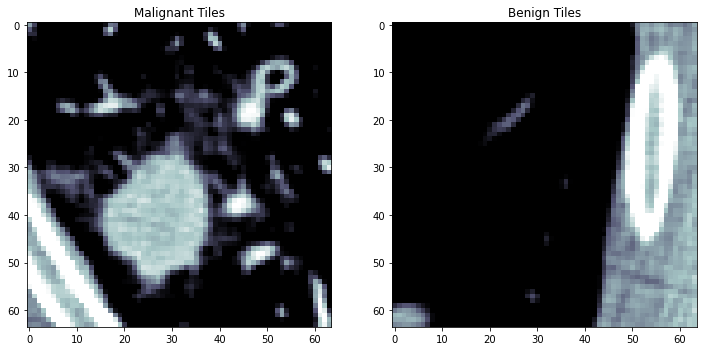

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12, 6))
plt_args = dict(cmap = 'bone', vmin = -600, vmax = 300)
ax1.imshow(montage(all_slices[np.random.choice(np.where(all_classes>0.5)[0],1)]), **plt_args)
ax1.set_title('Malignant Tiles')
ax2.imshow(montage(all_slices[np.random.choice(np.where(all_classes<0.5)[0],1)]), **plt_args)
ax2.set_title('Benign Tiles')

In [4]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization,Flatten,Dense
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"


def AlexNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(96, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = Convolution2D(256, (3, 3), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='relu_conv2')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool2')(x)

    x = Convolution2D(384, (3, 3), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='relu_conv3')(x)
    x = Convolution2D(384, (3, 3), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='relu_conv4')(x)
    x = Convolution2D(256, (3, 3), strides=(1, 1), padding='same', name='conv5')(x)
    x = Activation('relu', name='relu_conv5')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = Flatten()(x)
    x = Dense(units=4096,name='FCN1')(x)
    x = Activation('relu',name='relu_FCN1')(x)
    
    x = Dense(units=4096,name='FCN2')(x)
    x = Activation('relu',name='relu_FCN2')(x)
    
    x = Dense(units=2,name='FCN3')(x)
    out = Activation('softmax', name='loss')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='AlexNet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

Using TensorFlow backend.


In [5]:
import keras
lung_node_cnn = AlexNet(input_shape = (64, 64, 1), 
                           weights = None, classes = 2,
                  use_bn_on_input = True)
# initiate RMSprop optimizer
opt = keras.optimizers.Adam(lr=0.001, decay=1e-5)

# Let's train the model using RMSprop
lung_node_cnn.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
loss_history = []
lung_node_cnn.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 1)         4         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 31, 96)        960       
_________________________________________________________________
relu_conv1 (Activation)      (None, 31, 31, 96)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 15, 15, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 15, 15, 256)       221440    
_________________________________________________________________
relu_conv2 (Activation)      (None, 15, 15, 256)       0   

In [7]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(lung_node_cnn, to_file="D:/Users/asus/Alex_net.png", show_shapes=True)

# Image('D:/Users/asus/squeeze_net.png')
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
X_vec = (np.expand_dims(all_slices,-1) - np.mean(all_slices))/np.std(all_slices)

y_vec = to_categorical(all_classes)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, 
                                                   train_size = 0.75,
                                                   random_state = 1, 
                                                   stratify = all_classes)

In [8]:
from sklearn.metrics import classification_report
y_pred_proba = lung_node_cnn.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(np.argmax(y_test,1),
                      y_pred))

lung_node_cnn.save('AlexNet-8.h5')


              precision    recall  f1-score   support

           0       0.53      0.14      0.22      1041
           1       0.36      0.80      0.50       632

    accuracy                           0.39      1673
   macro avg       0.45      0.47      0.36      1673
weighted avg       0.47      0.39      0.33      1673



In [9]:
for i in range(5):
    loss_history += [lung_node_cnn.fit(X_train, y_train, 
              validation_data=(X_test, y_test),
                               shuffle = True,
                               batch_size = 32,
                               epochs = 1)]

Train on 5018 samples, validate on 1673 samples
Epoch 1/1
5018/5018 [==============================] - 123s 24ms/step - loss: 0.6480 - accuracy: 0.6321 - val_loss: 0.6231 - val_accuracy: 0.6503
Train on 5018 samples, validate on 1673 samples
Epoch 1/1
5018/5018 [==============================] - 122s 24ms/step - loss: 0.5995 - accuracy: 0.6873 - val_loss: 0.5818 - val_accuracy: 0.7274
Train on 5018 samples, validate on 1673 samples
Epoch 1/1
5018/5018 [==============================] - 123s 24ms/step - loss: 0.5573 - accuracy: 0.7264 - val_loss: 0.5506 - val_accuracy: 0.7125
Train on 5018 samples, validate on 1673 samples
Epoch 1/1
5018/5018 [==============================] - 123s 24ms/step - loss: 0.5146 - accuracy: 0.7565 - val_loss: 0.4816 - val_accuracy: 0.7932
Train on 5018 samples, validate on 1673 samples
Epoch 1/1
5018/5018 [==============================] - 125s 25ms/step - loss: 0.4745 - accuracy: 0.7822 - val_loss: 0.5050 - val_accuracy: 0.7484


Text(0.5, 1.0, 'Accuracy')

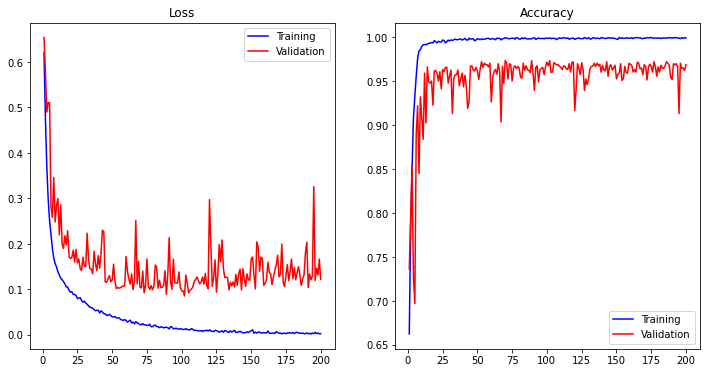

In [14]:
epich = np.cumsum(np.concatenate(
    [np.linspace(1, 1, len(mh.epoch)) for mh in loss_history]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate(
        [mh.history['val_loss'] for mh in loss_history]), 'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate(
    [mh.history['accuracy'] for mh in loss_history]), 'b-',
                 epich, np.concatenate(
        [mh.history['val_accuracy'] for mh in loss_history]),
                 'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Accuracy')

In [12]:
from sklearn.metrics import classification_report
y_pred_proba = lung_node_cnn.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(np.argmax(y_test,1),
                      y_pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1041
           1       0.98      0.94      0.96       632

    accuracy                           0.97      1673
   macro avg       0.97      0.96      0.97      1673
weighted avg       0.97      0.97      0.97      1673



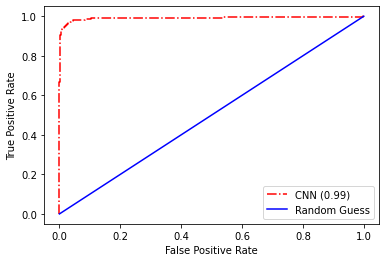

In [13]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), y_pred_proba[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()